In [ ]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
#------------------------------

#cpu - gpu configuration
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
keras.backend.set_session(sess)
#------------------------------

#variables
height = 48
width = 48
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 64
epochs = 1000
#------------------------------

#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("../images/fer2013/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))
#------------------------------

#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []
#------------------------------

#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")
#------------------------------

#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')
#------------------------------

#z-score normalization by subtracting mean
# and dividing by standard deviation
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train -= x_train_mean
x_test -= x_test_mean
x_train /= x_train_std 
x_test /= x_test_std

x_train = x_train.reshape(x_train.shape[0], width, height, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], width, height, 1)
x_test = x_test.astype('float32')

In [2]:
#create the convolutional neural network model
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))
#---------------------------------

#generate transformed images - remove inside parathesis to have no transformations
gen = ImageDataGenerator(width_shift_range=0.2,rotation_range=30, height_shift_range=0.2,
                        shear_range=30, horizontal_flip=True)

#visualise the transformations
# for batch in gen.flow(x_train[:10], batch_size=1):
#     x = batch[0][:, :, 0]
#     plt.imshow(x,cmap=plt.get_cmap('gray'))
#     plt.show()
    
val_gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
valid_generator = val_gen.flow(x_test, y_test, batch_size=batch_size)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#print out the model
model.summary()

#reduce learning rate when learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=3, verbose=1)

#stop learning when improvements are no longer found after X epochs
early_stopper = EarlyStopping(monitor='val_acc', patience=15, verbose=1)

#store the best accuracy seen so far
checkpointer = ModelCheckpoint('../models/MODEL_Turkey6_aug1.h5', monitor='val_acc', verbose=1, save_best_only=True)

#store logs of the learning process
tensorboard = TensorBoard(log_dir='../logs/Turkey6_aug1')

steps_train = train_generator.n//train_generator.batch_size
steps_valid = valid_generator.n//valid_generator.batch_size

#begin training
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=steps_train, 
                                  validation_steps = steps_valid,
                                  epochs=epochs, 
                                  validation_data=valid_generator,
                                  callbacks=[early_stopper, checkpointer, tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
__________

Epoch 18/1000
897/897 [==============================] - 74s 83ms/step - loss: 1.0156 - acc: 0.6294 - val_loss: 1.0516 - val_acc: 0.6284

Epoch 00018: val_acc did not improve from 0.63745
Epoch 19/1000
897/897 [==============================] - 74s 83ms/step - loss: 0.9752 - acc: 0.6436 - val_loss: 1.0256 - val_acc: 0.6250

Epoch 00019: val_acc did not improve from 0.63745
Epoch 20/1000
897/897 [==============================] - 74s 83ms/step - loss: 0.9506 - acc: 0.6537 - val_loss: 1.0398 - val_acc: 0.6272

Epoch 00020: val_acc did not improve from 0.63745
Epoch 21/1000
897/897 [==============================] - 74s 83ms/step - loss: 0.9498 - acc: 0.6518 - val_loss: 1.0283 - val_acc: 0.6389

Epoch 00021: val_acc improved from 0.63745 to 0.63887, saving model to ../models/MODEL_Turkey6_aug1.h5
Epoch 22/1000
897/897 [==============================] - 76s 85ms/step - loss: 0.9243 - acc: 0.6624 - val_loss: 0.9855 - val_acc: 0.6593

Epoch 00022: val_acc improved from 0.63887 to 0.65929, sa

Text(0.5,1,'Accuracy Curves')

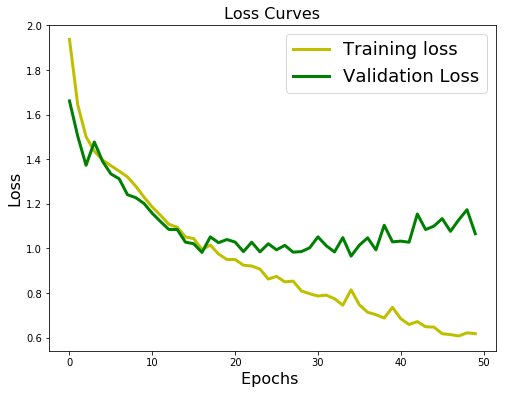

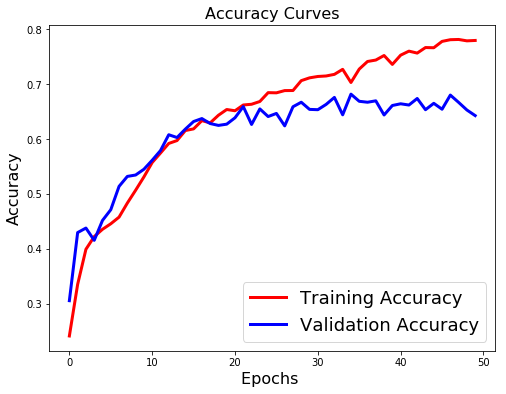

In [3]:
#plot graphs of training/validation losses
# and training/validation accuracies

#loss curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'y',linewidth=3.0)
plt.plot(history.history['val_loss'],'g',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
#accuracy curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [4]:
#determine a confusion matrix of the predicted labels vs actual labels
from sklearn.metrics import classification_report, confusion_matrix
 
pred_list = []; actual_list = []
p = model.predict(x_test)
for i in p:
    pred_list.append(np.argmax(i))

for i in y_test:
    actual_list.append(np.argmax(i))

confusion_matrix(actual_list, pred_list)

array([[229,   8,  49,  41,  56,   9,  75],
       [ 10,  29,   6,   2,   3,   1,   5],
       [ 29,   2, 174,  43, 106,  51,  91],
       [ 13,   1,   5, 805,  13,   7,  51],
       [ 52,   1,  42,  58, 323,  20, 157],
       [  8,   1,  20,  30,   9, 322,  25],
       [ 24,   1,  15,  60,  73,   7, 427]])